In [1]:
import os 
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import datetime
import re


In [2]:
# load data using pandas from csv files in Data_with mouse Id 
# Data_wite mouse Id is a folder in the same directory as this file
path = 'Data_with mouse ID/data'
files = os.listdir(path)
files = [path + '/' + file for file in files]
 
 # load a dict of files keyed with the file name
log_data = {file.split('/')[-1].split('.')[0]: pd.read_csv(file) for file in files}
# get array of file names 
file_names = list(log_data.keys())
file_names.sort()

mouse_name_list = ['M' + str(i) for i in range(1,9)]
mouse_break_times = dict(zip(mouse_name_list, np.empty((8, 2))))
successful_trials_by_day = dict()

In [3]:
def subtract_time_series(x, index1, index2):
    time_str1 = str(x[index1])
    time_str2 = str(x[index2])
    if time_str2 == 'nan':
        return None
    secs1 = float(str(x[index1])[12:14])
    secs2 = float(str(x[index2])[12:14])
    millis1 = float(str(x[index1])[14:])
    millis2 = float(str(x[index2])[14:])
    mins1 = float(str(x[index1])[10:12])
    mins2 = float(str(x[index2])[10:12])
    # divide millis until there is nothing to the right of the decimal point
    while millis1 > 1:
        millis1 /= 10
    while millis2 > 1:
        millis2 /= 10
    secs1 += millis1
    secs2 += millis2

    if secs2 < secs1:
        x =  abs(mins2 - mins1) * 60 + (secs2 - secs1) 
    else:
        x =  (secs2 - secs1) 
    return x


In [4]:
for file in file_names:
    df = log_data[file]
    matches = [ re.match('(M)[1-8]_[L | R]_beambreak_time in s', name) for name in df.columns.to_list()]
    for match in matches:
        if match is not None:
            if match.string.split('_')[1] == 'R':
                R = match.string
            else:
                L = match.string
    mouse_name_L = L.split('_')[0]
    mouse_name_R = R.split('_')[0]
    # subtract the 2nd collumn from the 4th abd 7th collumns
    mouse_L_break_time = df.apply(lambda x : subtract_time_series(x, 'cue_time in s', L), axis=1)
    mouse_R_break_time = df.apply(lambda x : subtract_time_series(x, 'cue_time in s', R), axis=1)
    # run through both to see when both broke the beam, then record as a success for the day
    sucessfull_trials = 0
    for i in range(len(mouse_L_break_time)):
        if mouse_L_break_time[i] is not None and mouse_R_break_time[i] is not None:
            sucessfull_trials += 1
    successful_trials_by_day[file] = {
        'names' : mouse_name_L + mouse_name_R,
        'L': mouse_L_break_time,
        'R': mouse_R_break_time,
        'successful_trials': sucessfull_trials}
    mouse_break_times[mouse_name_L] = np.concatenate((mouse_break_times[mouse_name_L], ( mouse_L_break_time.array)))
    mouse_break_times[mouse_name_R] = np.concatenate((mouse_break_times[mouse_name_R], ( mouse_R_break_time.array)))


{'20230712151237_log': {'names': 'M5M6',
  'L': 0      6.1
  1     28.0
  2      NaN
  3      4.0
  4      NaN
  5      2.0
  6      6.0
  7      3.0
  8      2.1
  9      NaN
  10     7.1
  11    11.0
  12     NaN
  13     1.0
  14     NaN
  15    12.0
  16     1.0
  17     NaN
  18     4.1
  dtype: float64,
  'R': 0      2.0
  1      NaN
  2      9.0
  3      1.0
  4      NaN
  5      NaN
  6      6.1
  7      NaN
  8      1.0
  9      7.0
  10     1.0
  11     NaN
  12    14.0
  13     NaN
  14     NaN
  15    20.0
  16     7.1
  17    13.0
  18     NaN
  dtype: float64,
  'successful_trials': 19},
 '20230712153221_log': {'names': 'M5M6',
  'L': 0     23.1
  1      NaN
  2      NaN
  3      9.1
  4      NaN
  5     10.0
  6      5.0
  7      9.0
  8     18.1
  9      NaN
  10    20.1
  11    23.1
  12    13.1
  13    30.0
  14     NaN
  15     NaN
  16    13.0
  17     NaN
  18     NaN
  19     NaN
  20    22.0
  21    26.1
  22    22.0
  23     NaN
  24    14.1
  25     NaN
  26   

In [6]:
# for each mose in mouse_break_times, plot a scatter plot of the break times
clean_mouse_break_times = dict()
for mouse in mouse_break_times:
    # remove all nan values
    clean_mouse_data = mouse_break_times[mouse][~np.isnan(mouse_break_times[mouse])]
    # remove first two values
    clean_mouse_data = clean_mouse_data[2:]
    # remove outlier values greater than 60
    clean_mouse_data = clean_mouse_data[clean_mouse_data < 60]
    clean_mouse_break_times[mouse] = clean_mouse_data
# for each mouse in mouse_break_times, plot a histogram of the break times
clean_mouse_break_times

{'M1': array([ 5.10204 ,  5.007556,  4.00729 ,  1.002399,  9.012071,  7.010221,
        10.047866,  9.019198,  8.016176,  6.013853, 13.020019,  9.017375,
        11.018781, 10.21739 , 13.021761,  7.009968,  6.546635,  3.013074,
         4.06159 ,  3.004747,  8.011824,  2.004796, 13.016903,  7.0103  ,
        11.014685,  3.005472,  8.011291,  9.013187,  4.006983,  2.004868,
         2.004891,  1.003407, 10.013622,  4.006941,  1.004833,  7.009921,
         1.003675,  5.007405,  7.009905,  3.005733,  1.003458,  1.004621,
         5.008411,  7.043496,  1.00339 ,  1.03619 ,  3.040729,  1.003505,
         1.004733,  3.005661,  1.003553,  1.004326,  7.010141,  1.003116,
         1.003622,  3.004855,  1.003993,  9.050569,  1.003385,  1.003588,
         1.003817,  5.007905,  8.163889,  1.003712,  9.044491,  1.3802  ,
         3.006612,  1.002752,  1.00347 ,  1.005181,  3.004834,  3.005745,
         3.05514 ,  1.00329 ,  1.006052,  1.003418,  5.007504,  6.337626,
         1.006565,  1.003436,  9

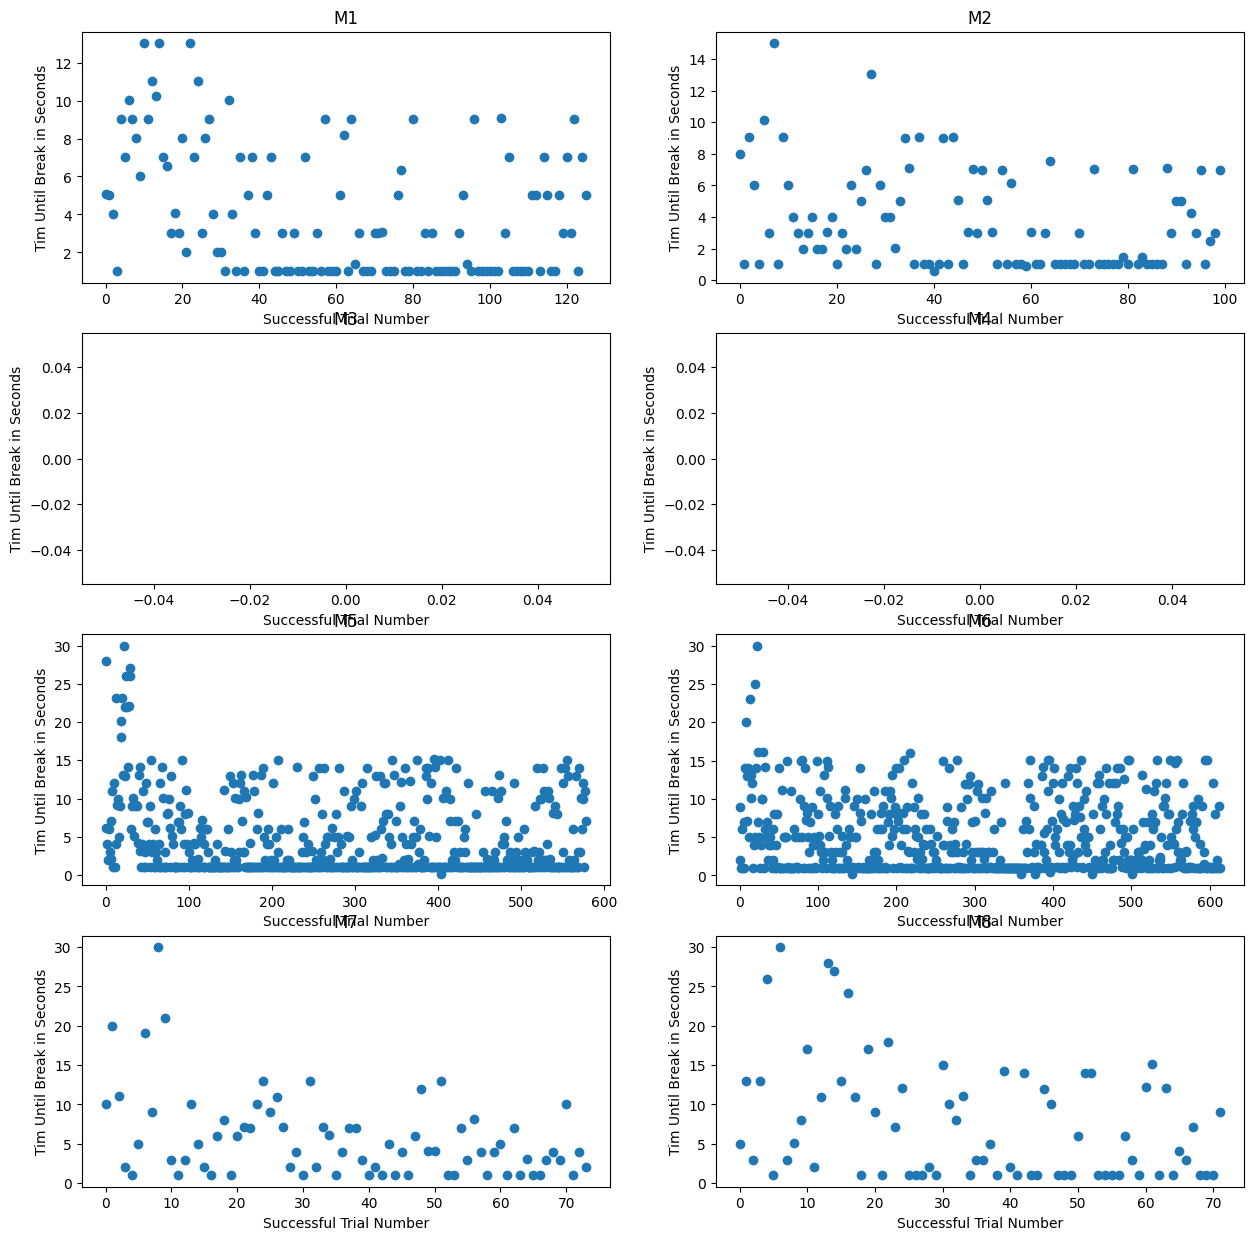

In [7]:
# create a scatter plot of each mouse and the distribution of break times
fig, axs = plt.subplots(4, 2, figsize=(15, 15))
axs = axs.ravel()
for i, mouse in enumerate(clean_mouse_break_times):
    axs[i].scatter(range(len(clean_mouse_break_times[mouse])), clean_mouse_break_times[mouse])
    axs[i].set_title(mouse)
    axs[i].set_xlabel('Successful Trial Number')
    axs[i].set_ylabel('Tim Until Break in Seconds')
plt.show()


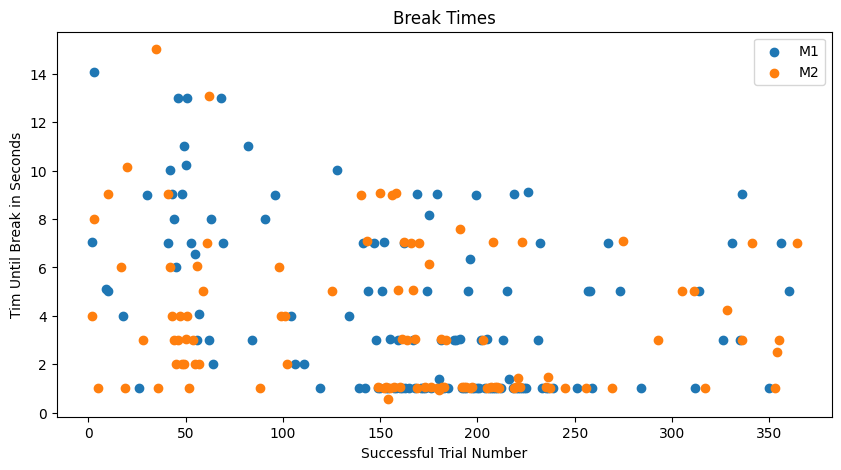

In [8]:
# create scatter plot of each mouse color coded
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for i, mouse in enumerate(mouse_break_times):
    if i > 1: break
    axs.scatter(range(len(mouse_break_times[mouse]))[2:], mouse_break_times[mouse][2:], label=mouse)
    axs.set_title('Break Times')
    axs.set_xlabel('Successful Trial Number')
    axs.set_ylabel('Tim Until Break in Seconds')
    axs.legend()

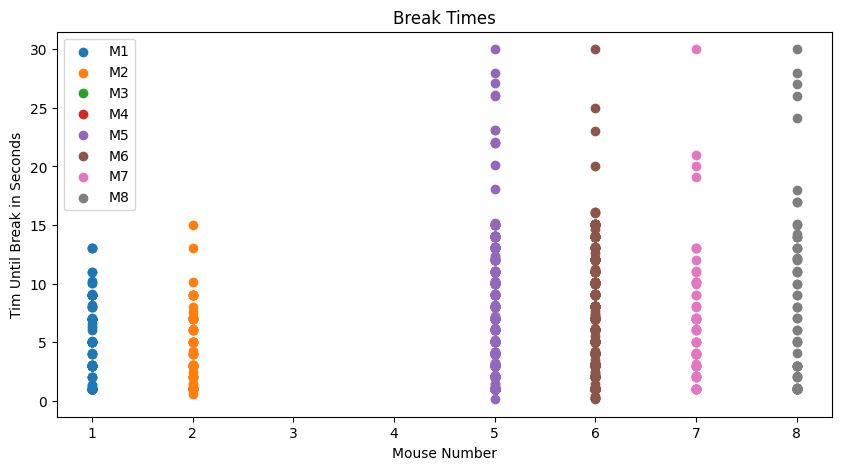

In [9]:
# plot a histogram of the break times for each mouse
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
for mouse in clean_mouse_break_times:
    axs.scatter( np.ones_like(clean_mouse_break_times[mouse]) * int(mouse.split('M')[1]), clean_mouse_break_times[mouse], label=mouse)
    axs.set_title('Break Times')
    axs.set_xlabel('Mouse Number')
    axs.set_ylabel('Tim Until Break in Seconds')
    axs.legend()
    

/tmp/ipykernel_142392/1695015274.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}
/tmp/ipykernel_142392/1695015274.py:4: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}


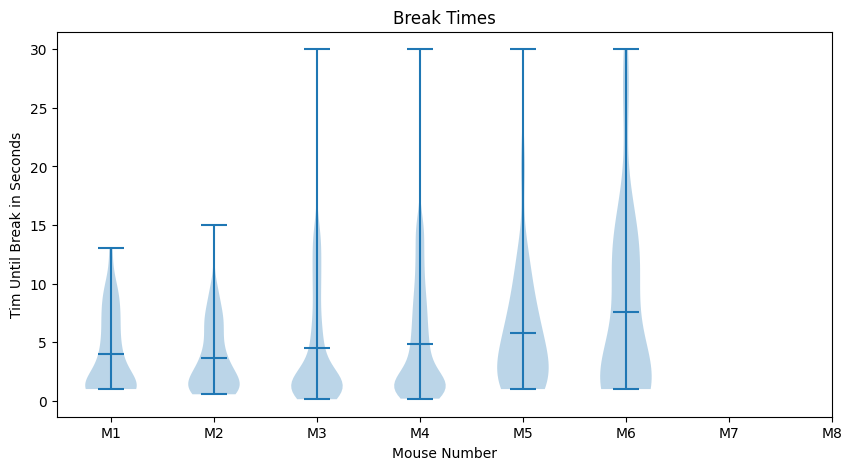

In [10]:
# violin plot of break times per mouse
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
# filter none values from dict
clean_mouse_break_times = {key: value for key, value in clean_mouse_break_times.items() if value != []}
mouse_break_array = (list(clean_mouse_break_times.values()))
axs.violinplot(mouse_break_array[0:8], showmeans=True)
axs.set_title('Break Times')
axs.set_xlabel('Mouse Number')
axs.set_ylabel('Tim Until Break in Seconds')
axs.set_xticks(range(1,9))
axs.set_xticklabels(mouse_name_list)
plt.show()
